In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

# Settings

In [4]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 4
IN_CHANNELS = 1
N_CLASSES = 1
EPOCH =200

WL=0
WW=1000

### Model Settings

#### encoder

In [5]:
ENCODER = "resnet152"
ENCODER_WEIGHT = None

#### decoder

In [6]:
DECODER_ATT = None

#### head

In [7]:
ACT = None
AUX_PARAM = None

### Optimizer Settings

In [8]:
OPTIM_NAME = "adam"
init_lr = 3e-4
momentum = 0.9

# Epochs

In [9]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR

In [10]:
def train_epoch(model, optimizer, dataloader, device):
  
    # change mode to train and move to current device
    model = model.train().to(device)

    mse_l = 0
    ssim_l = 0
    mae_l = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y = data

        x = x.to(device)
        y = y.to(device)

        y_pr = model(y)
        
        _mse = nn.MSELoss()(y_pr.float(), y.float())
        _mae = MAELoss()(y_pr.float(), y.float())
        _ssim =SSIMLoss()(y_pr, y, data_range=1, size_average=True) # return (N,)

        _loss = _mse + _ssim + _mae
                        
        
        optimizer.zero_grad()
        _loss.backward()
        optimizer.step()

        mse_l += _mse.item()
        ssim_l += _ssim.item()
        mae_l += _mae.item()

    return  mse_l/(index+1), mae_l/(index+1), ssim_l/(index+1)

In [11]:
@torch.no_grad()
def eval_epoch(model, dataloader, device):
  
    # change mode to train and move to current device
    model = model.eval().to(device)

    ssim_ = 0
    psnr_ = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y = data

        x = x.to(device)
        y = y.to(device)

        y_pr = model(y)
        
        _ssim = ssim(y, y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y, 1.0)

        ssim_ += _ssim.item()
        psnr_ += _psnr.item()

    return  ssim_/(index+1), psnr_/(index+1)

In [12]:
@torch.no_grad()
def test_epoch(model, dataloader, device):
  
    # change mode to train and move to current device
    model = model.eval().to(device)

    ssim = 0
    psnr = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y = data

        x = x.to(device)
        y = y.to(device)

        y_pr = model(y)

        x = x.squeeze().cpu().numpy()
        y = y.squeeze().cpu().numpy()
        y_pr = y_pr.squeeze().cpu().numpy() * 255
        y_pr = y_pr.astype(np.uint8)

        visualize(
            cbct = x,
            ct_y = y,
            ct_pred = y_pr,
        )

# Read Data

In [13]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [14]:
train_case_path = 'data/train/*_*'
test_case_path = 'data/test/*_*'

In [15]:
trainset = Dataset(path=train_case_path, intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation())
testset = Dataset(test_case_path, intensity_aug=aug.validation_intensity_augmentation(), geometry_aug=aug.get_validation_augmentation())

In [16]:
len(trainset), len(testset)

(1344, 191)

In [17]:
x, y = trainset[20]

In [18]:
np.min(x)

0.0

In [19]:
np.max(x)

1.0

(<matplotlib.image.AxesImage at 0x7f26add6fdf0>,)

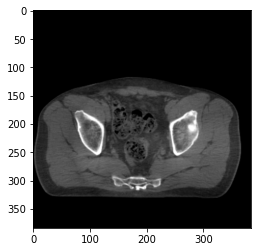

In [20]:
plt.imshow(x.squeeze(), 'gray'),

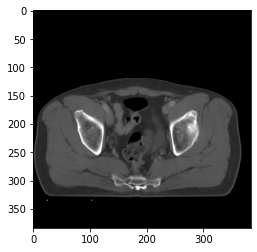

In [21]:
plt.imshow(y.squeeze(), 'gray')

In [22]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

## Model

In [23]:
class Model(nn.Module):
    def __init__(self, encoder, decoder, head):
        
        super(Model, self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.head = head
        
        
    def forward(self, x):
        
        x = self.encoder(x)[-1]
        x = self.decoder(*(None, None, None, None, x))
        x = self.head(x)
        
        return x

# Running

In [24]:
import wandb

wandb.init(project="ct_rebuild", config={
    "data": {
        "in_channels": IN_CHANNELS,
        "out_channels": N_CLASSES,
        "batchsize": BATCH,
    },
    "epochs": EPOCH,
    "model": {
        "optimizer": OPTIM_NAME,
        "init_lr": init_lr,
        "momentum": momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": ACT,
        "decoder_attention_type": DECODER_ATT
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [25]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4)

In [26]:
import segmentation_models_pytorch as smp
from codes.decoder import UnetDecoder
from segmentation_models_pytorch.base.heads import SegmentationHead

encoder = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=IN_CHANNELS, classes=N_CLASSES)
encoder = encoder.encoder

decoder = UnetDecoder(
                            encoder_channels=[IN_CHANNELS, 0, 0, 0, 0, 2048],
                            decoder_channels=[256, 128, 64, 32, 16],
                            n_blocks=5,
                            use_batchnorm=True,
                            attention_type=DECODER_ATT)

head = SegmentationHead(
                        in_channels=16,
                        out_channels=1,
                        activation=None)


model = Model(encoder, decoder, head)

del encoder, decoder, head

In [27]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
optimizer = Optimizer(model.parameters(), name=OPTIM_NAME, lr=init_lr)

In [ ]:
wandb.watch(model)

max_ssim = 0

for epoch in range(EPOCH):
        
        loss_mse, loss_mae, loss_ssim = train_epoch(model, optimizer, trainloader, device)
        score_ssim_train, score_psnr_train = eval_epoch(model, trainloader, device)
        score_ssim_test, score_psnr_test = eval_epoch(model, testloader, device)

        
        wandb.log({
            "mse loss": loss_mse,
            "mae loss": loss_mae,
            "ssim loss": loss_ssim,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test
        })
        
        
        if score_ssim_test > max_ssim:
            max_ssim = score_ssim_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict()
            }
            torch.save(checkpoint, os.path.join("{}.pth".format(wandb.run.name)))

336it [02:59,  1.88it/s]
336it [00:48,  6.93it/s]
48it [00:06,  7.08it/s]
336it [02:51,  1.96it/s]
336it [00:49,  6.82it/s]
48it [00:07,  6.67it/s]
336it [03:06,  1.81it/s]
336it [00:50,  6.69it/s]
48it [00:06,  7.08it/s]
336it [02:55,  1.91it/s]
336it [00:50,  6.69it/s]
48it [00:07,  6.65it/s]
336it [02:54,  1.92it/s]
336it [00:49,  6.75it/s]
48it [00:07,  6.70it/s]
336it [03:04,  1.82it/s]
336it [00:49,  6.82it/s]
48it [00:07,  6.71it/s]
336it [02:48,  2.00it/s]
336it [00:48,  6.98it/s]
48it [00:06,  7.61it/s]
336it [02:57,  1.89it/s]
336it [00:47,  7.00it/s]
48it [00:07,  6.65it/s]
336it [03:05,  1.81it/s]
336it [00:50,  6.69it/s]
48it [00:07,  6.63it/s]
336it [02:54,  1.92it/s]
336it [00:50,  6.68it/s]
48it [00:07,  6.65it/s]
336it [02:55,  1.92it/s]
336it [00:50,  6.69it/s]
48it [00:07,  6.66it/s]
336it [03:05,  1.81it/s]
336it [00:44,  7.49it/s]
48it [00:07,  6.64it/s]
336it [02:55,  1.91it/s]
336it [00:49,  6.82it/s]
48it [00:07,  6.76it/s]
336it [02:57,  1.89it/s]
336it [00:44,